# **Model and Evaluation**

## Objectives

* Develop an ML model that classifies leaf images into these two categories; healthy or containing powdery mildew (Business Requirement 2).

## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings.

```plaintext
├── inputs
│ └── cherryleaves_dataset
│ └── cherry-leaves
│   ├── test
│   │ ├── healthy
│   │ └── powdery_mildew
│   ├── train
│   │ ├── healthy
│   │ └── powdery_mildew
│   └── validation
│   │ ├── healthy
│   │ └── powdery_mildew
└── ...
``` 

## Outputs

* Image distribution plot in train, validation, and test set
* Image augementation for each set
* Class indices to change prediction inference in labels
* Creation of an ML model
* Display ML model summary
* Train ML model
* Save ML model
* Create Learning Curve Plot for model performance
* Model Evaluation on pickle file; determine accuracy, plot ROC curve, and calculate classification report 
* Plot Confusion Matrix
* Prediction on the random image file

## Comments

* The code in the notebook analyzes the distribution of images across training, validation, and test sets, followed by augmenting these images for training using techniques such as rotation, zoom, and flipping. It defines a convolutional neural network (CNN) model for detecting powdery mildew in cherry leaves, trains it with callbacks for early stopping and model checkpointing, and evaluates its performance using metrics such as accuracy, loss, ROC curve, and confusion matrix. Finally, it saves the trained model, generates classification reports, and predicts the class of new images based on the model’s outputs.

---

# Import Packages

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

# Set Working Directory

In [14]:
cwd = os.getcwd()

In [15]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [16]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

## Set Input Directories
Set train, validation and test paths

In [17]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [18]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [19]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set Image Shape

In [20]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Images Distribution

These plots will give you a comprehensive view of your dataset's distribution across different labels and sets, which is essential for understanding data balance and preparing for model training.

## Count Number of Images per Set & Label

In [21]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1919 images
* train - powdery_mildew: 1901 images
* test - healthy: 763 images
* test - powdery_mildew: 748 images
* validation - healthy: 402 images
* validation - powdery_mildew: 396 images




## Label Distribution - Bar Chart

In [22]:
fig = px.bar(df_freq, 
            x="Set", 
            y="Count", 
            color='Label', 
            title="Cherry Leaves Dataset", 
            text_auto=True)
fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_image(f'{file_path}/number_leaves_sets.png')

## Set Distribution

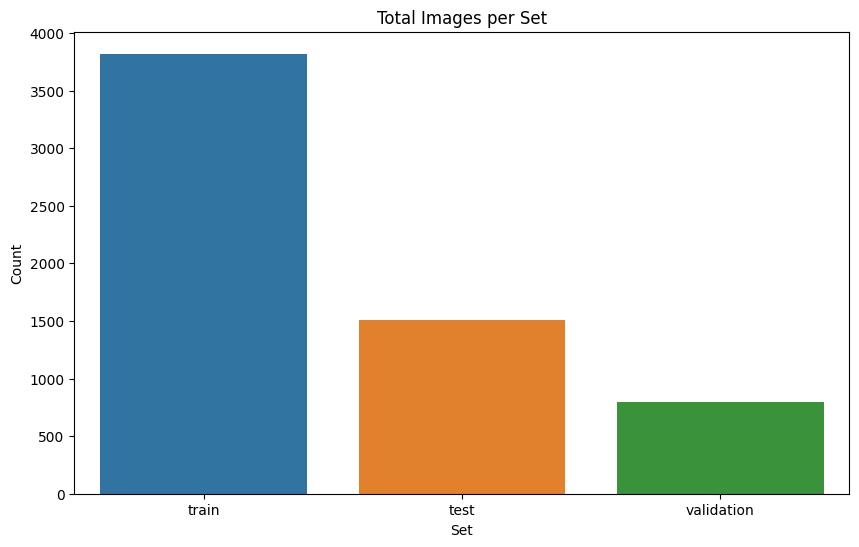

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_freq, x='Set', y='Count', estimator=sum, ci=None)
plt.title('Total Images per Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.savefig(f'{file_path}/sets_distribution_bar.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation
---

## Import ImageDataGenerator

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Initialize ImageDataGenerator

In [25]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Set Batch Size

In [26]:
batch_size = 18

## Augment Training Image Set

In [27]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 3820 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Training Image Set

(18, 256, 256, 3)


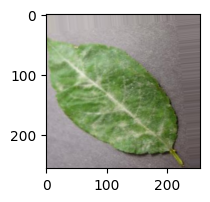

(18, 256, 256, 3)


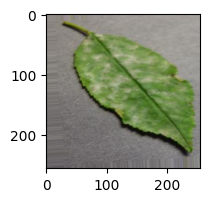

(18, 256, 256, 3)


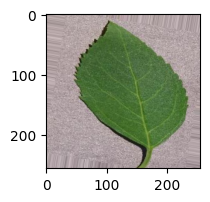

In [28]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Augment Validation Image Set

In [29]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 798 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Validation Image Set

(18, 256, 256, 3)


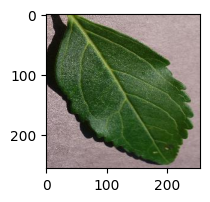

(18, 256, 256, 3)


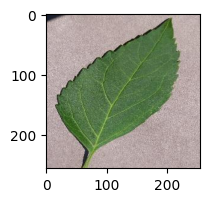

(18, 256, 256, 3)


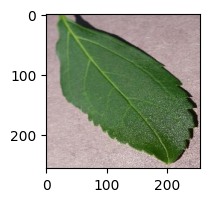

In [30]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Augment Test Image Set

In [31]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 1511 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Test Image Set

(18, 256, 256, 3)


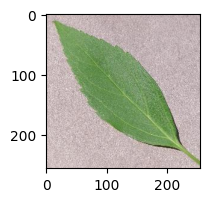

(18, 256, 256, 3)


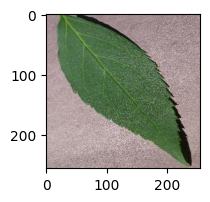

(18, 256, 256, 3)


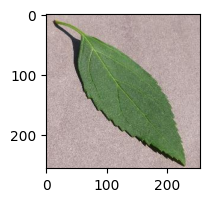

In [32]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [33]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

## Import Packages

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, Adagrad

## ML Model

In [35]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    ### fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

## Model Summary

In [36]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-09-12 09:57:32.718924: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Callbacks
Callbacks are a powerful feature in machine learning, particularly when training models using libraries like TensorFlow and Keras. They provide a mechanism to control and customize the training process, allowing users to take specific actions at various stages of the training lifecycle.

### EarlyStopping & ModelCheckPoint
* EarlyStopping is used to monitor the val_accuracy (validation accuracy). 
* If the validation accuracy does not improve for a set number of epochs (patience=2 in your case), training will stop. 
* This prevents overfitting, where the model becomes too specialized on the training data and performs poorly on unseen data (like validation or test sets).
---
* ModelCheckPoint monitors the val_accuracy and saves the model with the highest validation accuracy to the file path specified (outputs/v1/powdery_mildew_model.h5)
* This ensures that you have a copy of the best-performing model, which is crucial if you want to avoid retraining the model from scratch or in case of any interruptions during training. 
* Saving only the best model also helps manage storage efficiently, especially if the training process runs for many epochs.

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

## Fit Model for Model Training

In [38]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

2024-09-12 09:57:33.032924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32
212/212 [==============================] - 275s 1s/step - loss: 0.5276 - accuracy: 0.7475 - val_loss: 0.3152 - val_accuracy: 0.8772
Epoch 2/32
212/212 [==============================] - 275s 1s/step - loss: 0.3156 - accuracy: 0.8695 - val_loss: 0.2326 - val_accuracy: 0.9198
Epoch 3/32
212/212 [==============================] - 277s 1s/step - loss: 0.2553 - accuracy: 0.8966 - val_loss: 0.1834 - val_accuracy: 0.9361
Epoch 4/32
212/212 [==============================] - 272s 1s/step - loss: 0.2108 - accuracy: 0.9200 - val_loss: 0.1384 - val_accuracy: 0.9674
Epoch 5/32
212/212 [==============================] - 257s 1s/step - loss: 0.1587 - accuracy: 0.9484 - val_loss: 0.1768 - val_accuracy: 0.9286
Epoch 6/32
212/212 [==============================] - 271s 1s/step - loss: 0.1278 - accuracy: 0.9603 - val_loss: 0.1241 - val_accuracy: 0.9561
Epoch 00006: early stopping


## Save model

In [39]:
model.save('outputs/v1/powdery_mildew_model.h5')

---

# Model Performance

## Model Learning Curve A - Training, Validation, Loss & Accuracy Over Epochs

<Figure size 500x400 with 0 Axes>

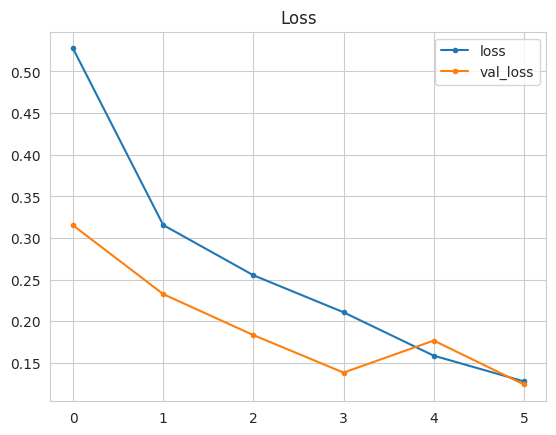

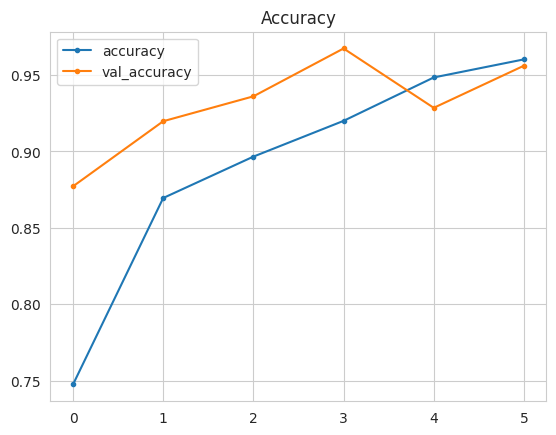

In [40]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Learning Curve B - Loss & Accuracy Over Training Epochs

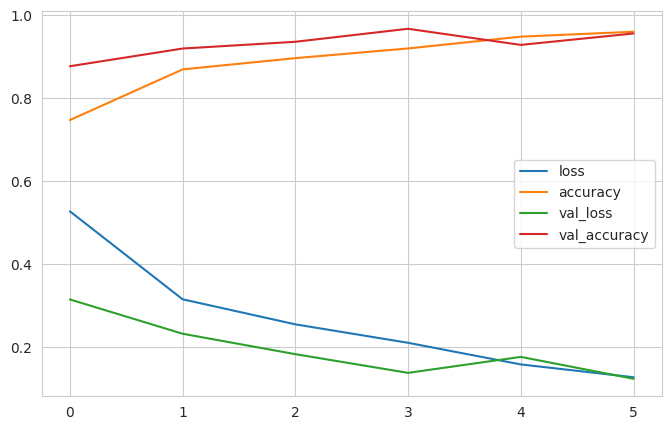

In [41]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.savefig(f'{file_path}/model_loss_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model Learning Curve C - Loss & Accuracy Metrics of Model's Training Process Over Multiple Epochs

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=model.history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=model.history.history['loss'], name="loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=model.history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter( y=model.history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

fig.update_xaxes(title_text="Epoch")

fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )

fig.show()
fig.write_image(f'{file_path}/model_history.png')

---

# Model Evaluation

## Import Packages

In [43]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

## Load Saved Model

In [44]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.h5')

## Evaluate Model Accuracy

In [45]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

84/84 [==============================] - 26s 307ms/step - loss: 0.1152 - accuracy: 0.9629
Model accuracy: 96.29%
Model Loss:  0.1151709258556366


## Set Accuracy Variables

In [46]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

## ROC Curve

Area Under ROC-Curve:  0.9625668449197862


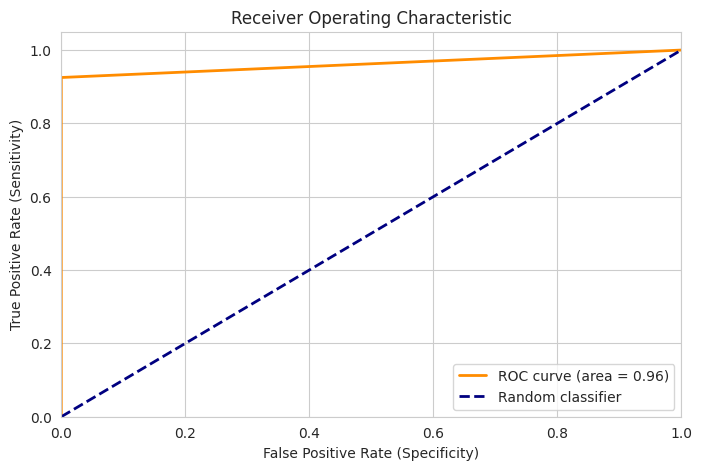

In [47]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

sns.set_style("whitegrid")

fpr, tpr, _ = roc_curve(y_true, y_pred) # fpr: False Positive Rate, tpr: True Positive Rate
roc_auc = auc(fpr, tpr) # Calculate the Area Under the Curve (AUC) for the ROC curve

plt.figure(figsize=(8, 5))

lw = 2

plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")

plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

## Confusion Matrix

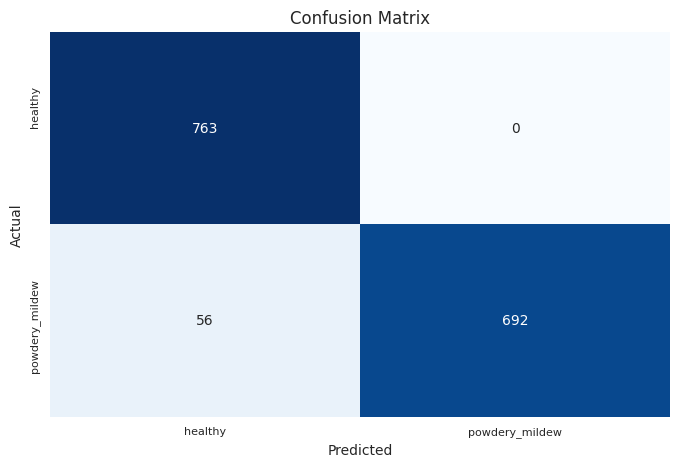

In [48]:
# Generate the confusion matrix based on the true and predicted labels
cm = confusion_matrix(y_true,y_pred)

# Retrieve the class names from the test set to label the axes of the confusion matrix
classes=list(test_set.class_indices.keys()) 

# Determine the number of classes
length=len(classes)

# Create a new figure for the confusion matrix plot with a specified figure size
plt.figure(figsize=(8, 5))

# Create a heatmap to visualise the confusion matrix
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       

# Set the tick marks for the x-axis
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)

# Set the tick marks for the y-axis
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)

plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Classification Report - A

In [49]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [50]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.93      1.00      0.96       763
powdery_mildew       1.00      0.93      0.96       748

      accuracy                           0.96      1511
     macro avg       0.97      0.96      0.96      1511
  weighted avg       0.97      0.96      0.96      1511



## Classification Report - B

Text(0.5, 1.0, 'Classification Report')

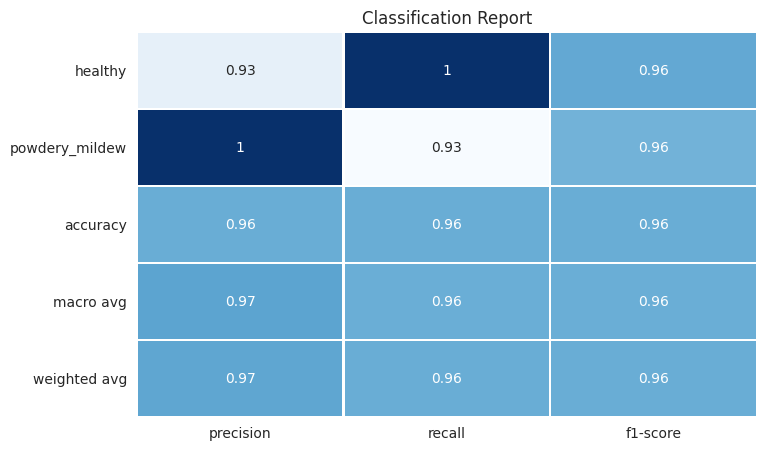

In [51]:
import matplotlib as mpl
clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')

## Classification Report - C

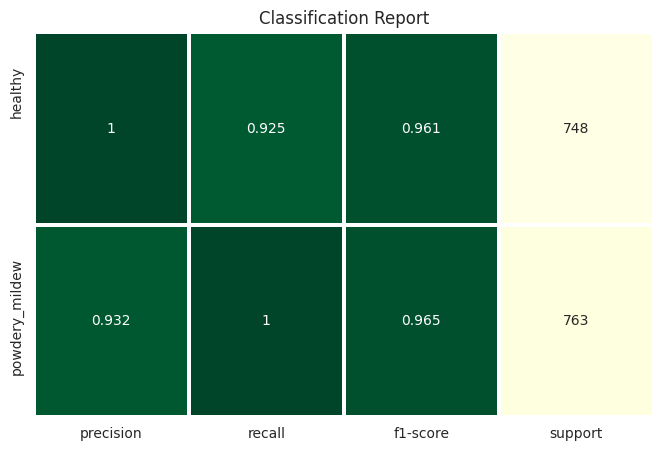

In [52]:
import matplotlib as mpl
import pathlib

def plot_classification_report(y_test, y_pred, title='Classification Report', save_fig_path=None, **kwargs):
    fig, ax = plt.subplots(figsize=(8,5))    
    clf_report = classification_report(y_true, y_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    df.sort_values(by=['support'], inplace=True) 
    
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
 
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", fmt='.3g', cbar=False,
            vmin=0.0,
            vmax=1.0,
            linewidths=.4, linecolor='white'
                    )
    
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),         
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    ) 
            
    plt.title(title)
    plt.yticks(np.arange(length)+.2, classes, rotation=90)
         
    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    
    return fig, ax

fig, ax = plot_classification_report(y_true, y_pred, 
                    title='Classification Report',
                    target_names=labels,
                    save_fig_path = f'{file_path}/clf_report.png',)

## Save Evaluation Pickle

In [53]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

# Predict On New Data

## Load Random Image as PIL

Image shape: (256, 256), Image mode: RGB


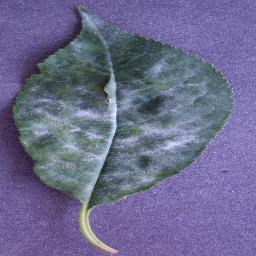

In [54]:
from tensorflow.keras.preprocessing import image

pointer = 76
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

## Convert Image To Array & Prepare for Prediction

In [55]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


## Predict Class Probabilities

In [56]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

powdery_mildew 99.68%


---